<a href="https://colab.research.google.com/github/MIKBRUNO/TPNS/blob/main/lab4/custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d oddrationale/mnist-in-csv

Dataset URL: https://www.kaggle.com/datasets/oddrationale/mnist-in-csv
License(s): CC0-1.0
 98% 15.0M/15.2M [00:01<00:00, 17.2MB/s]
100% 15.2M/15.2M [00:01<00:00, 9.30MB/s]


In [ ]:
!unzip mnist-in-csv.zip

Archive:  mnist-in-csv.zip
  inflating: mnist_test.csv          
  inflating: mnist_train.csv         


In [ ]:
import pandas as pd

In [ ]:
df_train = pd.read_csv("mnist_train.csv")
df_test = pd.read_csv("mnist_test.csv")

df_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train = df_train.drop("label", axis=1)
y_train = df_train["label"]

X_test = df_test.drop("label", axis=1)
y_test = df_test["label"]

<Axes: xlabel='label'>

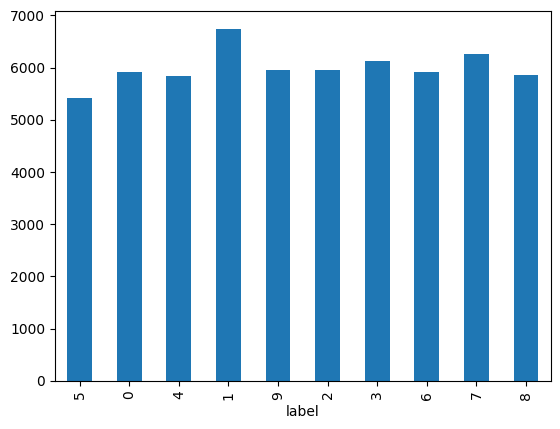

In [ ]:
y_train.value_counts(sort=False).plot.bar()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_digits(X, Y):
    for i in range(len(X)):
        plt.subplot(5, 4, i+1)
        plt.tight_layout()
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title('Digit:{}'.format(Y[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [ ]:
def plot_predictions(X, y_pred, n, r):
    for i in range(len(X)):
        plt.subplot(n, r*2, 2*i + 1)
        plt.tight_layout()
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.subplot(n, r*2, 2*i + 2)
        plt.bar(range(10), y_pred[i]*100)
    plt.show()

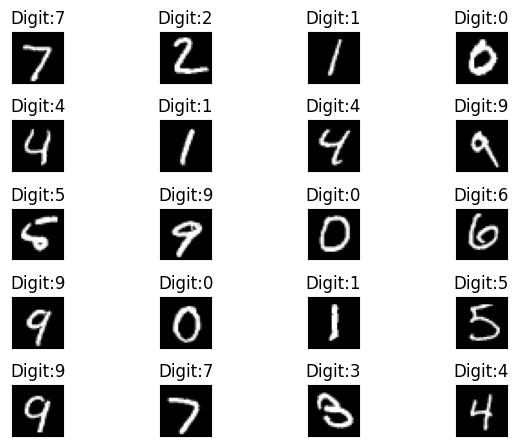

In [ ]:
plot_digits(X_test.iloc[:20].values, y_test.iloc[:20].values)

In [ ]:
X_train = X_train.values / 255.
X_test = X_test.values / 255.

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [ ]:
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [ ]:
import numpy as np

In [ ]:
X_train_32 = np.zeros((X_train.shape[0], 32, 32))
X_test_32 = np.zeros((X_test.shape[0], 32, 32))
for i in range(len(X_train)):
    X_train_32[i] = np.pad(X_train[i].reshape(28,28), 2, mode='constant', constant_values=(0,0))
for i in range(len(X_test)):
    X_test_32[i] = np.pad(X_test[i].reshape(28,28), 2, mode='constant', constant_values=(0,0))

# My Model

In [ ]:
import numpy as np
from numpy.typing import ArrayLike
from scipy.signal import correlate2d, convolve2d


class Differentiable:
    def __init__(self, f, df):
        self.__f__ = f
        self.__df__ = df

    def f(self, *arg):
        return self.__f__(*arg)

    def df(self, *arg):
        return self.__df__(*arg)


class Layer:
    def forward(self, X: ArrayLike) -> ArrayLike:
        raise NotImplementedError()

    def backward(self, previous_layer: ArrayLike, error: ArrayLike, learning_rate: float) -> ArrayLike:
        raise NotImplementedError()


class MyModel:
    def __init__(self, layers: list[Layer]):
        self.layers = layers

    def feed(self, X: ArrayLike) -> ArrayLike:
        for l in self.layers:
            X = l.forward(X)
        return X

    def evaluate(self, X: list[ArrayLike], Y: list[ArrayLike], loss: Differentiable):
        l = 0
        for x, y in zip(X, Y):
            x = self.feed(x)
            l += loss.f(x, y)
        return l / len(X)

    def fit(
        self,
        X: list[ArrayLike], Y: list[ArrayLike],
        X_test: list[ArrayLike], Y_test: list[ArrayLike],
        loss: Differentiable, learning_rate: float = 0.001,
        epochs: int = 2
    ):
        train_data = list(zip(X, Y))
        n = len(train_data)
        for j in range(epochs):
            np.random.shuffle(train_data)
            for x, y in train_data:
                inputs = []
                for l in self.layers:
                    inputs.append(x)
                    x = l.forward(x)
                e = loss.df(x, y)
                for l in reversed(self.layers):
                    e = l.backward(inputs.pop(), e, learning_rate)
            print(f"Epoch {j} complete! Loss: {self.evaluate(X, Y, loss=loss)}")


class DenseLayer(Layer):
    def __init__(self, input_dim: int, neurons: int):
        self.weights = np.random.rand(neurons, input_dim)*2 - 1
        self.biases = np.random.rand(neurons)*2 - 1

    def forward(self, X: ArrayLike) -> ArrayLike:
        return np.matmul(self.weights, X) + self.biases

    def backward(self, previous_layer: ArrayLike, error: ArrayLike, learning_rate: float) -> ArrayLike:
        back = np.matmul(np.transpose(self.weights), error)
        self.biases -= learning_rate * error
        self.weights -= learning_rate * np.outer(error, previous_layer)
        return back


class ConvLayer(Layer):
    def __init__(self, input_shape, kernels: int, kernel_size: int):
        self.input_shape = input_shape
        self.kernels = np.random.rand(kernels, input_shape[0], kernel_size, kernel_size)
        self.biases = np.random.rand(kernels, input_shape[1] - kernel_size + 1, input_shape[2] - kernel_size + 1)

    def forward(self, X: ArrayLike) -> ArrayLike:
        output = np.copy(self.biases)
        for depth in range(self.kernels.shape[0]):
            for i in range(self.kernels.shape[1]):
                output += correlate2d(X[i], self.kernels[depth][i], 'valid')
        return output

    def backward(self, previous_layer: ArrayLike, error: ArrayLike, learning_rate: float) -> ArrayLike:
        nabla_ker = np.zeros(self.kernels.shape)
        nabla_in = np.zeros(self.input_shape)

        for i in range(self.kernels.shape[0]):
            for j in range(self.input_shape[0]):
                nabla_ker[i, j] = correlate2d(previous_layer[j], error[i], "valid")
                nabla_in[j] += convolve2d(error[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * nabla_ker
        self.biases -= learning_rate * error
        return nabla_in


class SubSamplLayer(Layer):
    def __init__(self, input_shape, kernel_size: int):
        self.input_depth = input_shape[0]
        self.input_height = input_shape[1]
        self.input_width = input_shape[2]
        self.kernel_size = kernel_size
        if self.input_width % kernel_size != 0 or self.input_height % kernel_size != 0:
            raise Exception("bad kernel size")

    def forward(self, X: ArrayLike) -> ArrayLike:
        output_height = self.input_height // self.kernel_size
        output_width = self.input_width // self.kernel_size
        Y = np.zeros((self.input_depth, output_height, output_width))
        for depth in range(self.input_depth):
            for i in range(output_height):
                for j in range(output_width):
                    Y[depth][i, j] = np.mean(X[depth][
                        self.kernel_size * i : self.kernel_size * (i+1),
                        self.kernel_size * j : self.kernel_size * (j+1)
                        ])
        return Y

    def backward(self, previous_layer: ArrayLike, error: ArrayLike, learning_rate: float) -> ArrayLike:
        X_error = np.zeros((self.input_depth, self.input_height, self.input_width))
        for d in range(self.input_depth):
            for i in range(self.input_height):
                for j in range(self.input_width):
                    X_error[d][i, j] = error[d][i // self.kernel_size, j // self.kernel_size]
        return X_error / (self.kernel_size ** 2)


class ReshapeLayer(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, X: ArrayLike) -> ArrayLike:
        return np.reshape(X, self.output_shape)

    def backward(self, previous_layer: ArrayLike, error: ArrayLike, learning_rate: float) -> ArrayLike:
        return np.reshape(error, self.input_shape)


class Activation(Layer):
    def __init__(self, activation: Differentiable):
        self.func = activation

    def forward(self, X: ArrayLike) -> ArrayLike:
        return self.func.f(X)

    def backward(self, previous_layer: ArrayLike, error: ArrayLike, learning_rate: float) -> ArrayLike:
        return self.func.df(previous_layer) * error


def reluf(x):
    return np.max([0, x])


def relu(x):
    return np.max(np.array([np.zeros(x.shape, dtype=x.dtype), x]), axis=0)


def linear(x: np.dtype) -> np.dtype:
    return x


def sigmoid(x: np.dtype) -> np.dtype:
    return 1 / (1 + np.exp(-x))


def softmax(x: ArrayLike):
    e = np.exp(x)
    sums = np.tile(np.sum(e), np.size(e,0))
    return e / sums


def mse(y_pred: ArrayLike, y: ArrayLike):
    return np.mean(np.power(y - y_pred, 2))


def crossentropy(y_pred: ArrayLike, y: ArrayLike):
    return -np.mean(y * np.log(y_pred))


drelu = Differentiable(relu, np.vectorize(lambda x: 0 if x < 0 else 1))
dsigmoid = Differentiable(sigmoid, lambda x: sigmoid(x) * (1 - sigmoid(x)))
dlinear = Differentiable(linear, lambda x: np.ones(x.shape))

dmse = Differentiable(mse, lambda y_pred, y: 2 * (y_pred - y))


class SoftMaxCrossEntropyModelWrapper:
    def __init__(self, model: MyModel):
        self.model = model

    def feed(self, X: ArrayLike) -> ArrayLike:
        return softmax(self.model.feed(X))

    def evaluate(self, X: list[ArrayLike], Y: list[ArrayLike]):
        l = 0
        for x, y in zip(X, Y):
            x = self.feed(x)
            l += crossentropy(x, y)
            print(f'\r {np.argmax(y)} == {np.argmax(x)}', end='')
        print()
        print(l / len(X))
        return l / len(X)

    def presoftmax_loss_error(self, presoftmax, y):
        return (y + softmax(presoftmax) * np.sum(y)) / np.size(y,0)

    def fit(
        self,
        X: list[ArrayLike], Y: list[ArrayLike],
        X_test: list[ArrayLike], Y_test: list[ArrayLike],
        learning_rate: float = 0.001,
        epochs: int = 2
    ):
        train_data = list(zip(X, Y))
        for j in range(epochs):
            np.random.shuffle(train_data)
            i = 0
            for x, y in train_data:
                inputs = []
                for l in self.model.layers:
                    inputs.append(x)
                    x = l.forward(x)
                e = self.presoftmax_loss_error(x, y)
                for l in reversed(self.model.layers):
                    e = l.backward(inputs.pop(), e, learning_rate)
                print(f"\rComplete {i}", end='')
                i += 1
            print(f"\nEpoch {j} complete! Loss: {self.evaluate(X, Y)}")


In [ ]:
model = SoftMaxCrossEntropyModelWrapper(
    MyModel([
        ConvLayer((1, 32, 32), 6, 5),
        Activation(drelu),
        SubSamplLayer((6, 28, 28), 2),
        ConvLayer((6, 14, 14), 16, 5),
        Activation(drelu),
        SubSamplLayer((16, 10, 10), 2),
        ConvLayer((16, 5, 5), 120, 5),
        ReshapeLayer((120, 1, 1), (120,)),
        Activation(drelu),
        DenseLayer(120, 84),
        Activation(drelu),
        DenseLayer(84, 10)
    ])
)

In [ ]:
model.feed(
        X_test_32.reshape(len(X_test_32), 1, 32, 32)[0] #, y_test[:20]
)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [ ]:
model.fit(
    X_test_32.reshape(len(X_test_32), 1, 32, 32), y_test,
    X_test_32.reshape(len(X_test_32), 1, 32, 32), y_test,
    epochs=1
)

<ipython-input-18-2a3bb59ad57d>:177: RuntimeWarning: overflow encountered in exp
  e = np.exp(x)
<ipython-input-18-2a3bb59ad57d>:179: RuntimeWarning: invalid value encountered in divide
  return e / sums
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


 6 == 0

KeyboardInterrupt: 